**Problem Statement** : <br>
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Step - 01 Importing Libraries**

In [ ]:
import pathlib  #used for working with filesystem paths
import tensorflow as tf #tensorflow, the main machine learning library
import matplotlib.pyplot as plt #matplotlib for plotting
import numpy as np #NumPy for numerical operations
import pandas as pd #Pandas for data manipulation
import os #operating system module for interacting with the file system
import PIL #python imaging library for image processing
from tensorflow import keras #Keras, a high level neural networks API running on top of Tensorflow
from tensorflow.keras import layers #various layers and modules from keras and TensorFlow for building neural networks
from tensorflow.keras.models import Sequential #the sequential class is a linear stack of layers used to build neural network models layer by layer.
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam # - importing the adam optimizer for model training
import random # Python's random module for generating random numbers
from glob import glob #used for file path pattern matching
import seaborn as sns #seaborn for statistical data visualization
from tensorflow.keras.losses import SparseCategoricalCrossentropy #importing a specific loss function
import matplotlib.pyplot as plt
import matplotlib.image as img #matplotlib for handling image data
import warnings #python warnings module to control warning messages
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #setting the tensorflow logging level to suppress unnecessary messages
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) #setting the tensorflow V1 logging verbosity level to suppress unnecessary messages

In [ ]:
# CHECK FOR AVAILABLE GPUS
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)

#SET THE MEMORY GROWTH FOR EACH GPU
if gpus :
    try :
        for gpu in gpus :
          tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs, ", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e :
      print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs,  1 Logical GPUs


**Step - 02 Reading Data**

In [ ]:
data_dir_train = pathlib.Path('/content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train');
data_dir_test = pathlib.Path('/content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Test');

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')));
image_count_test = len(list(data_dir_test.glob('*/*.jpg')));
print(image_count_train)
print(image_count_test)

2239
118


**Load using keras.preprocessing** <br>
Let's load these images off disk using the helpful image_dataset_from_directory utility.

**Step - 03 Create a dataset**
<br>
<br>
Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180
image_size = (img_height,img_width)
#rnd_seed = 123
#random.seed(rnd_seed)

Use 80% of the images for training, and 20% for validation.

In [ ]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [ ]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [ ]:
len(train_ds), len(val_ds)

(56, 14)

In [ ]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
num_classes = len(class_names)
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
# Get list of directories in data_dir_train
labels = os.listdir(data_dir_train)

# Create label_map dictionary
label_map = {i: label for i, label in enumerate(labels)}
num_classes=len(label_map)
label_map

{0: 'dermatofibroma',
 1: 'pigmented benign keratosis',
 2: 'vascular lesion',
 3: 'nevus',
 4: 'basal cell carcinoma',
 5: 'melanoma',
 6: 'actinic keratosis',
 7: 'squamous cell carcinoma',
 8: 'seborrheic keratosis'}

**Visualize the data**

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32, 9)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

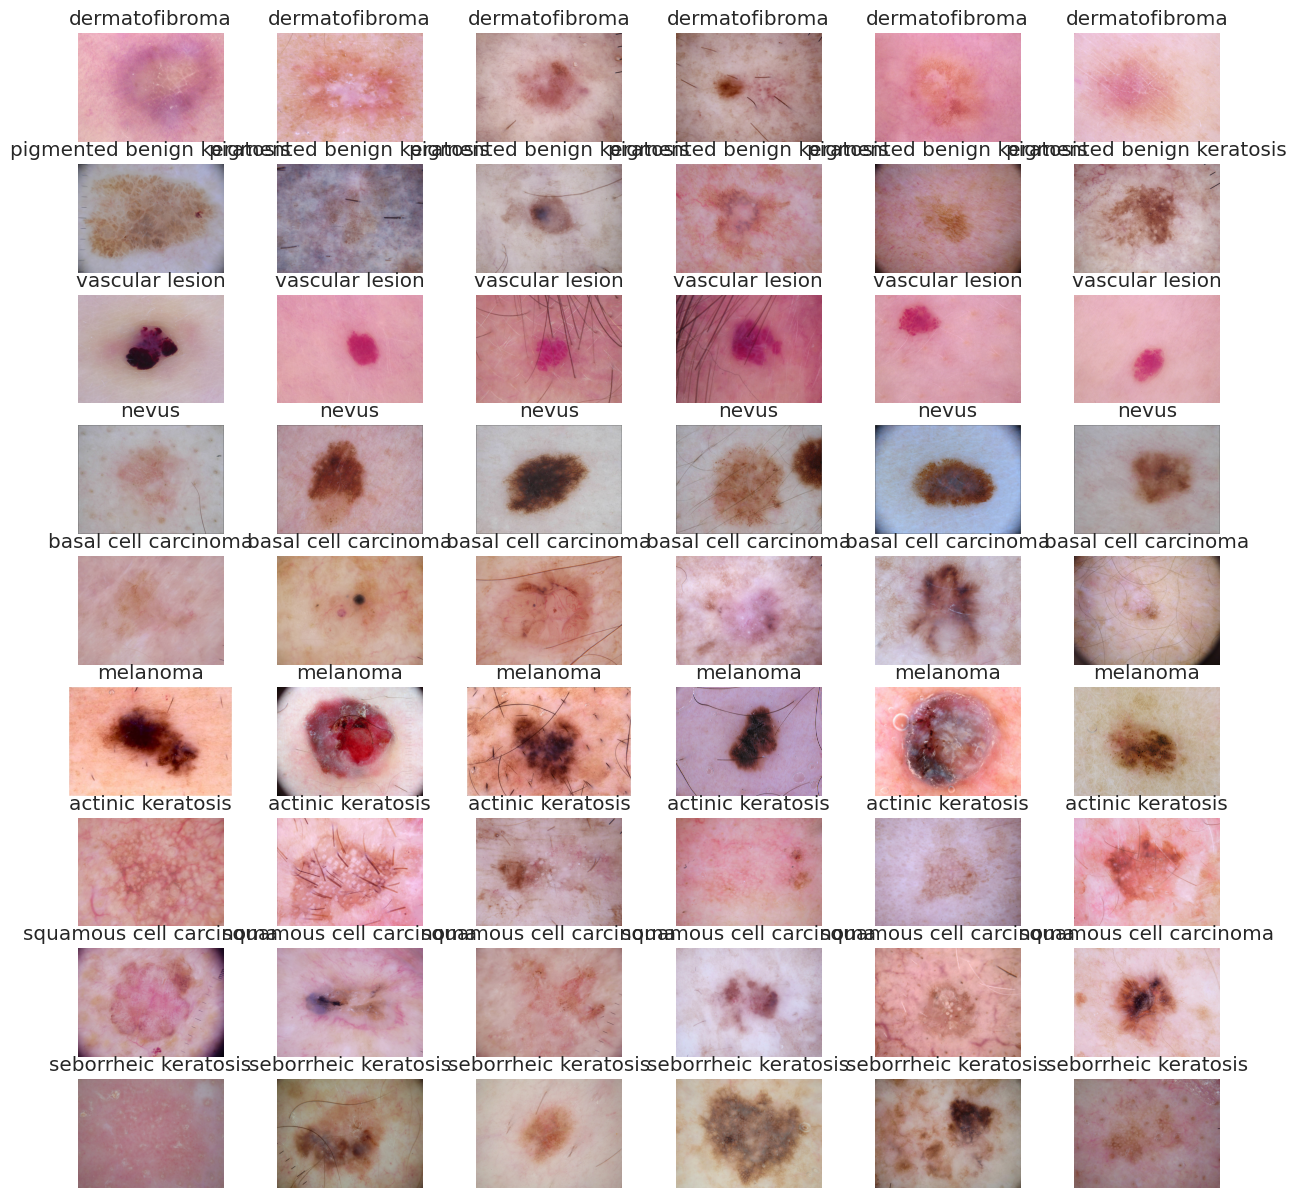

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib

# Assuming data_dir_train contains subdirectories for each class
data_dir_train = pathlib.Path('/content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train')

# Get list of directories in data_dir_train
class_directories = [subdir for subdir in data_dir_train.glob('*') if subdir.is_dir()]

# Set the number of images to display for each class
num_images_per_class = 6

# Create a figure
plt.figure(figsize=(15, 15))

# Loop through each class directory
for i, class_dir in enumerate(class_directories):
    # Get the class name from the directory name
    class_name = class_dir.name

    # Get a list of image files in the class directory
    image_files = list(class_dir.glob('*.jpg'))

    # Display the first num_images_per_class images for each class
    for j in range(min(num_images_per_class, len(image_files))):
        img_path = image_files[j]

        # Read and display the image
        img = mpimg.imread(img_path)
        plt.subplot(len(class_directories), num_images_per_class, i * num_images_per_class + j + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')

# Show the plot
plt.show()

### Step - 4 Model 1 (Basic Model)
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [ ]:
### Your code goes here
def make_model(input_shape, num_classes):
    print(input_shape)
    inputs = keras.Input(shape=input_shape)
    print("Inputs : " ,inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    print(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    print(x)
    x = layers.BatchNormalization()(x)
    print(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    units = num_classes

    # x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
#keras.utils.plot_model(model, show_shapes=True)


(180, 180, 3)
Inputs :  KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), name='rescaling/add:0', description="created by layer 'rescaling'")
KerasTensor(type_spec=TensorSpec(shape=(None, 90, 90, 64), dtype=tf.float32, name=None), name='conv2d/BiasAdd:0', description="created by layer 'conv2d'")
KerasTensor(type_spec=TensorSpec(shape=(None, 90, 90, 64), dtype=tf.float32, name=None), name='batch_normalization/FusedBatchNormV3:0', description="created by layer 'batch_normalization'")


### Compile the model 1
Choose an appropirate optimiser and loss function for model training

**Compiling Model with lr = 0.001**

In [ ]:
### Todo, choose an appropirate optimiser and loss function
lr = 0.001
model.compile(optimizer=keras.optimizers.Adam(lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Precision','Recall','AUC'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 180, 180, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 90, 90, 64)           1792      ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 90, 90, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                               

**Train the model with lr = 0.001**

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 681s 3s/step - loss: 1.6631 - accuracy: 0.4035 - precision: 0.5594 - recall: 0.1814 - auc: 0.8157 - val_loss: 2.1815 - val_accuracy: 0.1544 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5948
Epoch 2/25
56/56 [==============================] - 9s 158ms/step - loss: 1.4887 - accuracy: 0.4548 - precision: 0.6339 - recall: 0.2483 - auc: 0.8543 - val_loss: 2.1754 - val_accuracy: 0.1499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5802
Epoch 3/25
56/56 [==============================] - 9s 160ms/step - loss: 1.4486 - accuracy: 0.4866 - precision: 0.6344 - recall: 0.2857 - auc: 0.8637 - val_loss: 2.1862 - val_accuracy: 0.1499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5551
Epoch 4/25
56/56 [==============================] - 9s 160ms/step - loss: 1.4303 - accuracy: 0.4827 - precision: 0.6322 - recall: 0.2695 - auc: 0.8677 - val_loss: 2.2302 - val_accuracy: 0.0537 - val_precision:

**Visualizing Training Results**

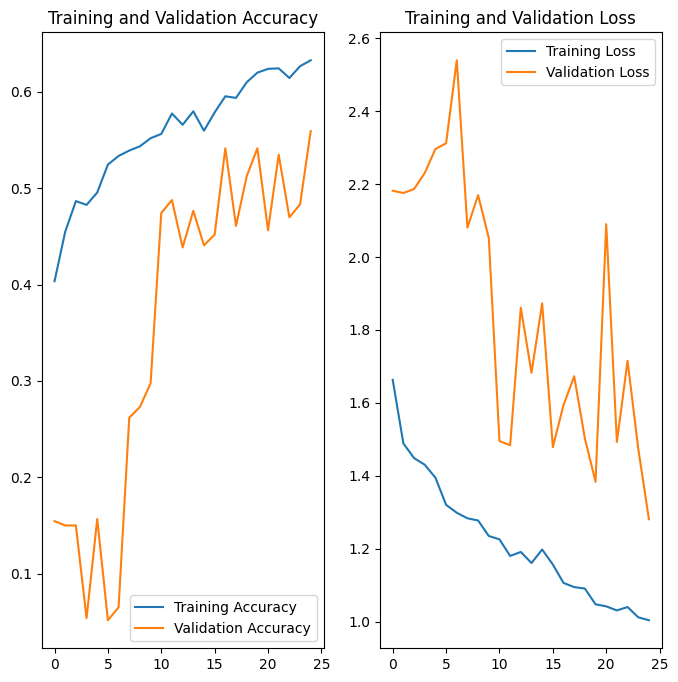

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Compiling Model with lr = 0.0001**


In [ ]:
### Your code goes here
def make_model(input_shape, num_classes):
    print(input_shape)
    inputs = keras.Input(shape=input_shape)
    print("Inputs : " ,inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    print(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    print(x)
    x = layers.BatchNormalization()(x)
    print(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    units = num_classes

    # x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
#keras.utils.plot_model(model, show_shapes=True)


(180, 180, 3)
Inputs :  KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), name='rescaling_1/add:0', description="created by layer 'rescaling_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 90, 90, 64), dtype=tf.float32, name=None), name='conv2d_3/BiasAdd:0', description="created by layer 'conv2d_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 90, 90, 64), dtype=tf.float32, name=None), name='batch_normalization_5/FusedBatchNormV3:0', description="created by layer 'batch_normalization_5'")


In [ ]:
### Todo, choose an appropirate optimiser and loss function
lr = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Precision','Recall','AUC'])

**Train the model with lr = 0.0001**

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 13s 166ms/step - loss: 1.7661 - accuracy: 0.3717 - precision: 0.6506 - recall: 0.0904 - auc: 0.7812 - val_loss: 2.1798 - val_accuracy: 0.2058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6446
Epoch 2/25
56/56 [==============================] - 9s 155ms/step - loss: 1.4992 - accuracy: 0.4570 - precision: 0.7032 - recall: 0.2115 - auc: 0.8524 - val_loss: 2.1706 - val_accuracy: 0.2058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6367
Epoch 3/25
56/56 [==============================] - 9s 153ms/step - loss: 1.4301 - accuracy: 0.4788 - precision: 0.6966 - recall: 0.2511 - auc: 0.8662 - val_loss: 2.1639 - val_accuracy: 0.2058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6362
Epoch 4/25
56/56 [==============================] - 9s 158ms/step - loss: 1.3975 - accuracy: 0.4939 - precision: 0.7149 - recall: 0.2645 - auc: 0.8729 - val_loss: 2.1596 - val_accuracy: 0.0537 - val_precisio

**Visualizing Training Results**

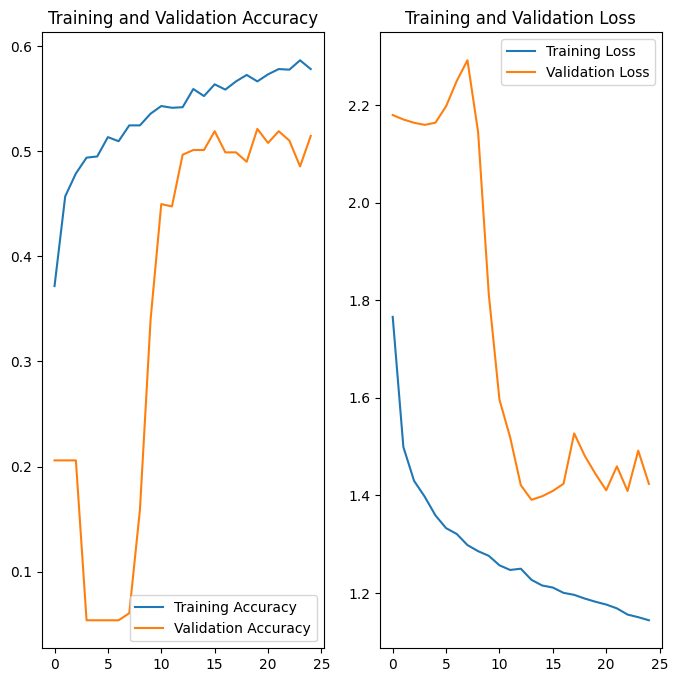

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Confusion Matrix**

In [ ]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  validation_split=0.9,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 106 files for validation.


In [ ]:
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

4/4 [==============================] - 48s 165ms/step
Accuracy: 0.3584905660377358
Confusion Matrix:
[[ 2  5  1  1  1  2  0  2  0]
 [ 0  8  0  0  1  2  0  2  2]
 [ 0  5  2  5  0  1  0  1  1]
 [ 0  0  0  4  6  0  0  0  3]
 [ 0  0  0  2 13  1  0  0  0]
 [ 1  5  0  1  0  5  0  0  0]
 [ 0  0  0  3  0  0  0  0  0]
 [ 0  7  0  3  1  3  0  2  0]
 [ 0  0  0  0  0  0  0  0  2]]


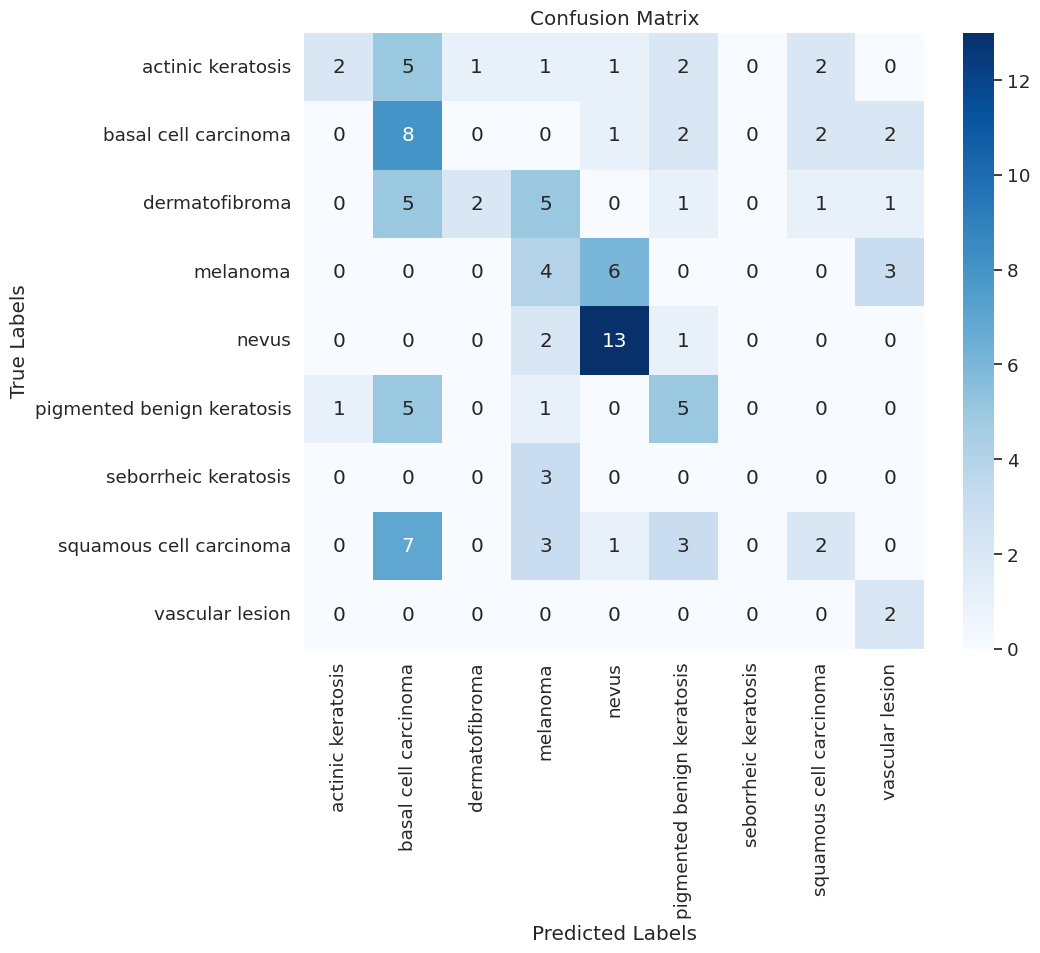

Class: actinic keratosis
Precision: 0.6666666666666666
Recall: 0.14285714285714285
-------------------
Class: basal cell carcinoma
Precision: 0.26666666666666666
Recall: 0.5333333333333333
-------------------
Class: dermatofibroma
Precision: 0.6666666666666666
Recall: 0.13333333333333333
-------------------
Class: melanoma
Precision: 0.21052631578947367
Recall: 0.3076923076923077
-------------------
Class: nevus
Precision: 0.5909090909090909
Recall: 0.8125
-------------------
Class: pigmented benign keratosis
Precision: 0.35714285714285715
Recall: 0.4166666666666667
-------------------
Class: seborrheic keratosis
Precision: 0.0
Recall: 0.0
-------------------
Class: squamous cell carcinoma
Precision: 0.2857142857142857
Recall: 0.125
-------------------
Class: vascular lesion
Precision: 0.25
Recall: 1.0
-------------------


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# Assuming class_names is defined as a list of your class names
# class_names = [...]

y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for _, y in test_ds], axis=0)

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)

conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

precision_per_class = precision_score(y_true, y_pred, average=None)
recall_per_class = recall_score(y_true, y_pred, average=None)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Display precision and recall per class
for class_idx, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"Precision: {precision_per_class[class_idx]}")
    print(f"Recall: {recall_per_class[class_idx]}")
    print("-------------------")


**Conclusion**


*   The model is overfitting because we can see the difference in accuracy in training data & accuracy in the validation data.

* The training accuracy is just around 63.45% with 25 epochos and the model is yet to learn the many features.

* Data imbalance might be causing the bais to the model.



**Step 4 : Model 2 (Data Augumentation with drop out layer)**

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

## **Create Model - lr - 0.001**

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
#keras.utils.plot_model(model, show_shapes=True)

**Compile the model 2** <br>
Choose an appropirate optimiser and loss function for model training

In [ ]:
## Your code goes here
lr = 0.001
model.compile(optimizer=keras.optimizers.Adam(lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Precision','Recall','AUC'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 rescaling_2 (Rescaling)     (None, 180, 180, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv2d_6 (Conv2D)           (None, 90, 90, 32)           896       ['rescaling_2[0][0]']         
                                                                                                  
 batch_normalization_10 (Ba  (None, 90, 90, 32)           128       ['conv2d_6[0][0]']            
 tchNormalization)                                                                          

**Training The Model**

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 15s 172ms/step - loss: 1.7399 - accuracy: 0.3722 - precision: 0.5450 - recall: 0.1959 - auc: 0.7997 - val_loss: 2.1826 - val_accuracy: 0.1499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5997
Epoch 2/25
56/56 [==============================] - 8s 150ms/step - loss: 1.5546 - accuracy: 0.4442 - precision: 0.6030 - recall: 0.2254 - auc: 0.8429 - val_loss: 2.1776 - val_accuracy: 0.1499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5669
Epoch 3/25
56/56 [==============================] - 9s 155ms/step - loss: 1.5138 - accuracy: 0.4503 - precision: 0.6035 - recall: 0.2472 - auc: 0.8508 - val_loss: 2.1646 - val_accuracy: 0.1499 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5853
Epoch 4/25
56/56 [==============================] - 9s 155ms/step - loss: 1.4688 - accuracy: 0.4554 - precision: 0.6307 - recall: 0.2706 - auc: 0.8597 - val_loss: 2.1779 - val_accuracy: 0.1544 - val_precisio

**Visualizing The Result**

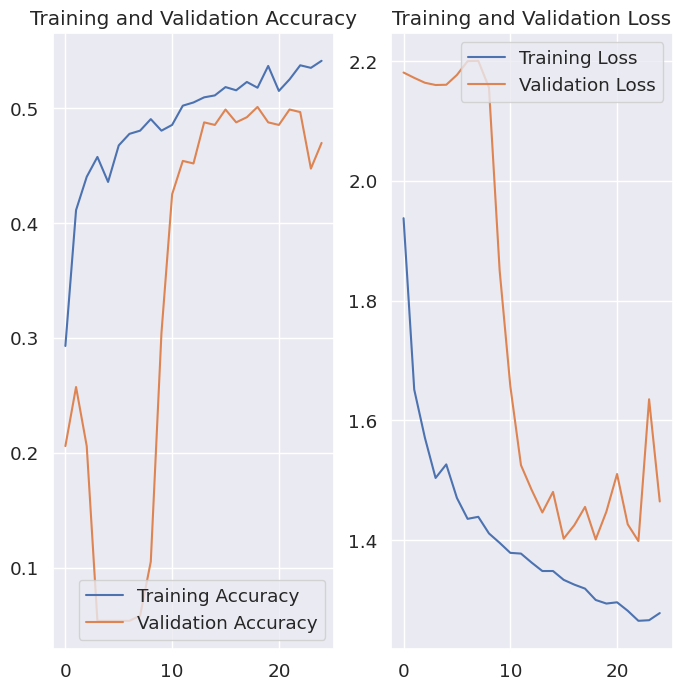

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Create Model - lr - 0.0001**

In [ ]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = "softmax"
    units = num_classes

    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=num_classes)
#keras.utils.plot_model(model, show_shapes=True)

**Compile the model 2** <br>
Choose an appropirate optimiser and loss function for model training

In [ ]:
## Your code goes here
lr = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Precision','Recall','AUC'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 rescaling_3 (Rescaling)     (None, 180, 180, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv2d_9 (Conv2D)           (None, 90, 90, 32)           896       ['rescaling_3[0][0]']         
                                                                                                  
 batch_normalization_15 (Ba  (None, 90, 90, 32)           128       ['conv2d_9[0][0]']            
 tchNormalization)                                                                          

**Training The Model**

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
56/56 [==============================] - 14s 153ms/step - loss: 1.9377 - accuracy: 0.2930 - precision: 0.5938 - recall: 0.0742 - auc: 0.7201 - val_loss: 2.1809 - val_accuracy: 0.2058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6182
Epoch 2/25
56/56 [==============================] - 8s 149ms/step - loss: 1.6515 - accuracy: 0.4113 - precision: 0.6204 - recall: 0.1897 - auc: 0.8150 - val_loss: 2.1720 - val_accuracy: 0.2573 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6253
Epoch 3/25
56/56 [==============================] - 8s 149ms/step - loss: 1.5711 - accuracy: 0.4403 - precision: 0.6248 - recall: 0.2109 - auc: 0.8356 - val_loss: 2.1638 - val_accuracy: 0.2058 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5987
Epoch 4/25
56/56 [==============================] - 8s 151ms/step - loss: 1.5040 - accuracy: 0.4576 - precision: 0.6560 - recall: 0.2522 - auc: 0.8508 - val_loss: 2.1601 - val_accuracy: 0.0537 - val_precisio

**Visualizing The Result**

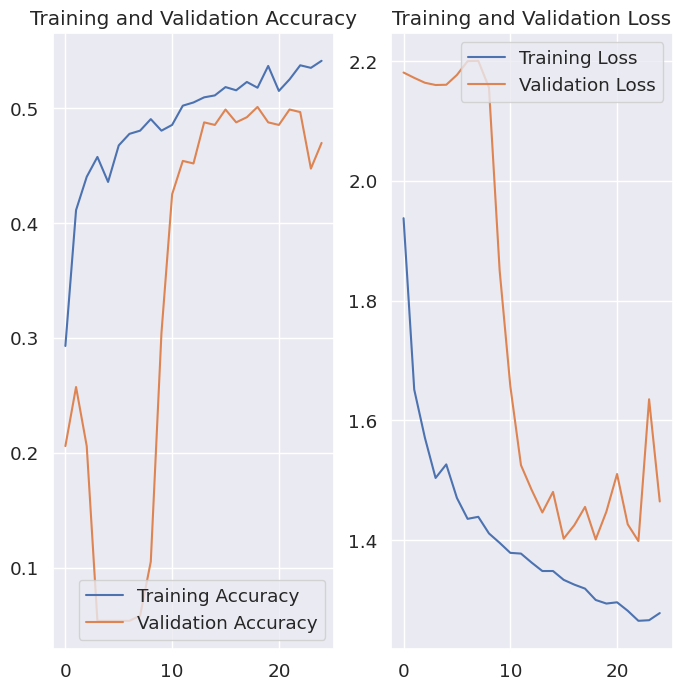

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion**
* With data agumenatation and drop layer, the overfitting of the model is adressed to great extend.
* The accuracy of the model is decreased by certain percents.
Considering above 2 points, there is still a scope of lot of improvement of the model.

## **Step 6 Analysing the class imbalance of the data**

total training image count = 2239 

-------------------------------------
Class name =  actinic keratosis
count      =  114
proportion =  0.05091558731576597
-------------------------------------
Class name =  basal cell carcinoma
count      =  376
proportion =  0.16793211255024565
-------------------------------------
Class name =  dermatofibroma
count      =  95
proportion =  0.04242965609647164
-------------------------------------
Class name =  melanoma
count      =  438
proportion =  0.19562304600267977
-------------------------------------
Class name =  nevus
count      =  357
proportion =  0.15944618133095131
-------------------------------------
Class name =  pigmented benign keratosis
count      =  462
proportion =  0.20634211701652524
-------------------------------------
Class name =  seborrheic keratosis
count      =  77
proportion =  0.03439035283608754
-------------------------------------
Class name =  squamous cell carcinoma
count      =  181
proportion =  0.08083966056

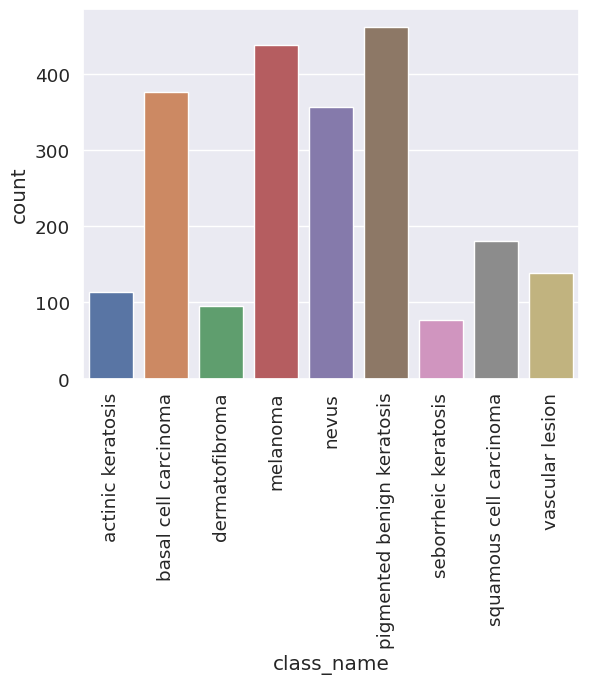

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

**Conclusion**

* Data is heavily imbalance and hence due to that results and predictions will be baised

## **Step 7 : Augmentor (Class balance)**

In [ ]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.

Define a number of operations to perform on this data set using your Pipeline object.

Execute these operations by calling the Pipeline’s sample() method.

In [ ]:
path_to_training_dataset =str(data_dir_train)
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    print(i)
    p = Augmentor.Pipeline(path_to_training_dataset+"/"+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train
actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E9031C9FC40>: 100%|██████████| 1000/1000 [00:53<00:00, 18.54 Samples/s]


basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E9032A12710>: 100%|██████████| 1000/1000 [00:50<00:00, 19.90 Samples/s]


dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E9031C9FC40>: 100%|██████████| 1000/1000 [00:40<00:00, 24.98 Samples/s]


melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2048x1536 at 0x7E90C018DA50>: 100%|██████████| 1000/1000 [03:08<00:00,  5.31 Samples/s]


nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7E90AFF8EC20>: 100%|██████████| 1000/1000 [02:36<00:00,  6.40 Samples/s]


pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E9031C9CFD0>: 100%|██████████| 1000/1000 [00:39<00:00, 25.30 Samples/s]


seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E9032AB6A10>: 100%|██████████| 1000/1000 [01:22<00:00, 12.08 Samples/s]


squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E904DB61810>: 100%|██████████| 1000/1000 [00:37<00:00, 27.02 Samples/s]


vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E908397EE00>: 100%|██████████| 1000/1000 [00:37<00:00, 26.53 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

9000


**Lets see the distribution of augmented data after adding new images to the original training data.**

total training image count = 9000 

-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  1000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  1000
proportion =  0.11111111

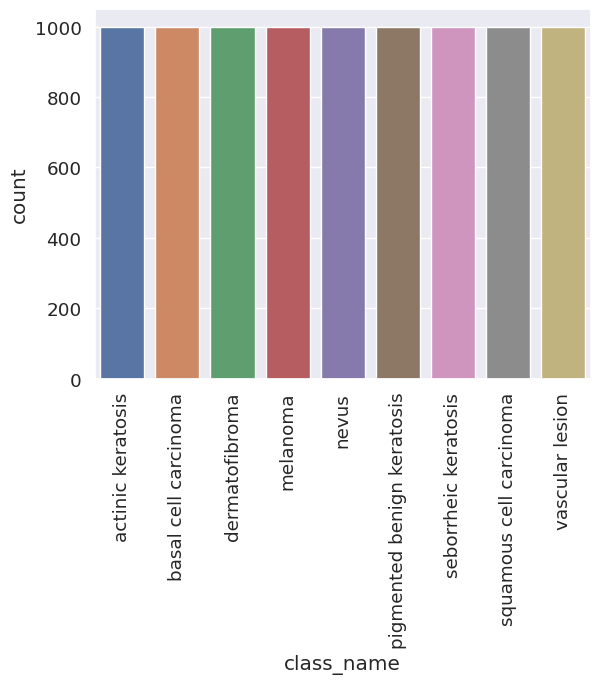

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [ ]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df=df2
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

dermatofibroma                2000
pigmented benign keratosis    2000
vascular lesion               2000
nevus                         2000
basal cell carcinoma          2000
melanoma                      2000
actinic keratosis             2000
squamous cell carcinoma       2000
seborrheic keratosis          2000
Name: Label, dtype: int64

So, now we have added 1000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

**Step 8 : Model 3 (Model with Class balance data)**

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

**Create a training dataset**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 11239 files belonging to 9 classes.
Using 8992 files for training.


**Create a validation dataset**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 11239 files belonging to 9 classes.
Using 2247 files for validation.


## **Create Model - lr - 0.001**

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [128, 256]:  # Experiment with different sizes
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    activation = "softmax"
    units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=num_classes)


In [ ]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
lr = 0.001
model.compile(optimizer=keras.optimizers.Adam(lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Precision','Recall','AUC'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_5[0][0]']             
                                                                                                  
 rescaling_4 (Rescaling)     (None, 180, 180, 3)          0         ['sequential[2][0]']          
                                                                                                  
 conv2d_12 (Conv2D)          (None, 90, 90, 32)           896       ['rescaling_4[0][0]']         
                                                                                            

In [ ]:
#Training the model
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
281/281 [==============================] - 89s 282ms/step - loss: 1.6987 - accuracy: 0.3590 - precision: 0.5645 - recall: 0.1528 - auc: 0.8059 - val_loss: 2.3696 - val_accuracy: 0.1064 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5407
Epoch 2/25
281/281 [==============================] - 66s 231ms/step - loss: 1.4520 - accuracy: 0.4441 - precision: 0.6256 - recall: 0.2301 - auc: 0.8635 - val_loss: 1.6207 - val_accuracy: 0.3792 - val_precision: 0.5512 - val_recall: 0.1798 - val_auc: 0.8269
Epoch 3/25
281/281 [==============================] - 75s 264ms/step - loss: 1.3480 - accuracy: 0.4761 - precision: 0.6478 - recall: 0.2705 - auc: 0.8841 - val_loss: 2.0924 - val_accuracy: 0.3551 - val_precision: 0.5322 - val_recall: 0.2390 - val_auc: 0.7620
Epoch 4/25
281/281 [==============================] - 66s 233ms/step - loss: 1.2724 - accuracy: 0.5022 - precision: 0.6596 - recall: 0.3026 - auc: 0.8973 - val_loss: 1.4965 - val_accuracy: 0.4339 - val_precision: 0.

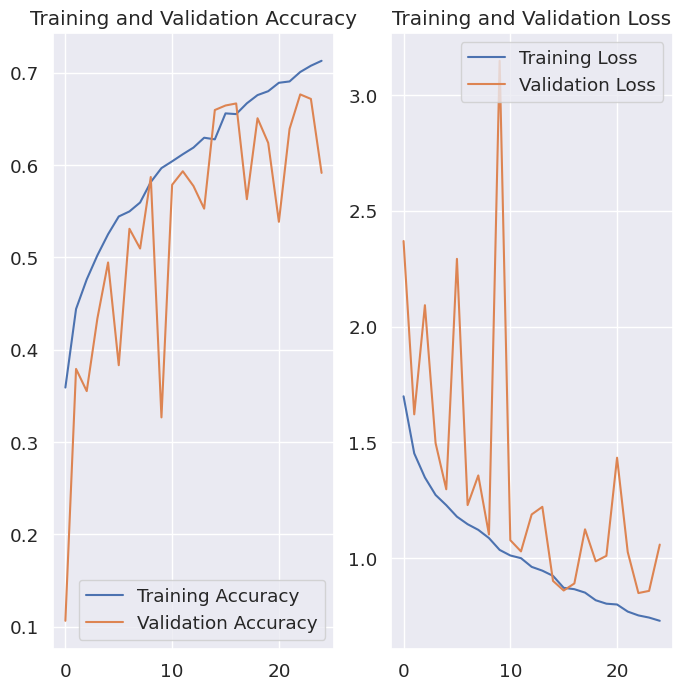

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Create Model - lr - 0.0001**

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [128, 256]:  # Experiment with different sizes
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    activation = "softmax"
    units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=num_classes)


In [ ]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
lr = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Precision','Recall','AUC'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_6[0][0]']             
                                                                                                  
 rescaling_5 (Rescaling)     (None, 180, 180, 3)          0         ['sequential[3][0]']          
                                                                                                  
 conv2d_16 (Conv2D)          (None, 90, 90, 32)           896       ['rescaling_5[0][0]']         
                                                                                            

In [ ]:
#Training the model
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
281/281 [==============================] - 80s 253ms/step - loss: 1.7528 - accuracy: 0.3250 - precision: 0.5550 - recall: 0.1140 - auc: 0.7870 - val_loss: 2.2159 - val_accuracy: 0.1064 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5312
Epoch 2/25
281/281 [==============================] - 67s 236ms/step - loss: 1.5265 - accuracy: 0.4109 - precision: 0.6065 - recall: 0.1985 - auc: 0.8474 - val_loss: 1.8855 - val_accuracy: 0.3004 - val_precision: 0.7794 - val_recall: 0.0236 - val_auc: 0.7465
Epoch 3/25
281/281 [==============================] - 66s 232ms/step - loss: 1.4595 - accuracy: 0.4355 - precision: 0.6326 - recall: 0.2215 - auc: 0.8612 - val_loss: 1.3636 - val_accuracy: 0.4695 - val_precision: 0.7054 - val_recall: 0.2163 - val_auc: 0.8812
Epoch 4/25
281/281 [==============================] - 68s 237ms/step - loss: 1.4034 - accuracy: 0.4577 - precision: 0.6582 - recall: 0.2527 - auc: 0.8726 - val_loss: 1.3073 - val_accuracy: 0.4962 - val_precision: 0.

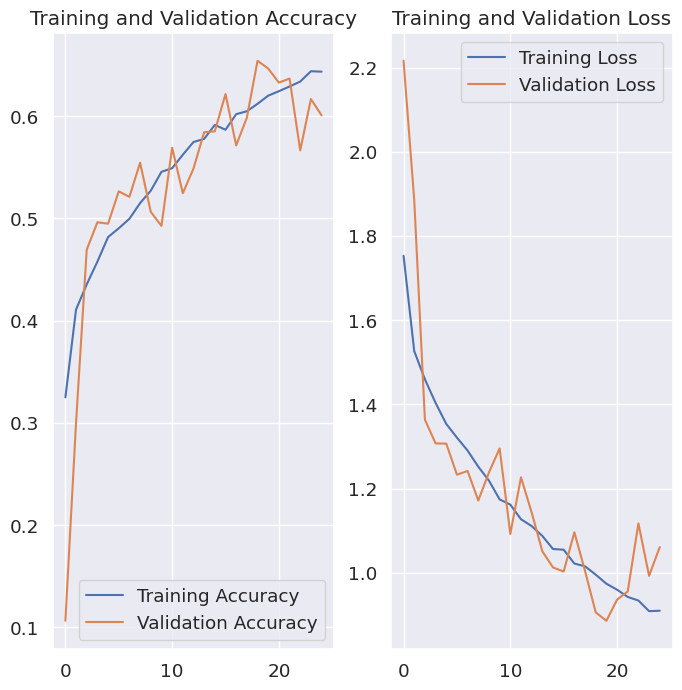

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## **Step - 9**
Training Model on 16000 Images

In [ ]:
path_to_training_dataset =str(data_dir_train)
#path_to_training_dataset= "Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    print(i)
    p = Augmentor.Pipeline(path_to_training_dataset+"/"+ i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train
actinic keratosis
Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E9033993160>: 100%|██████████| 1000/1000 [00:36<00:00, 27.48 Samples/s]


basal cell carcinoma
Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E90338B3040>: 100%|██████████| 1000/1000 [00:35<00:00, 27.83 Samples/s]


dermatofibroma
Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E906058C1C0>: 100%|██████████| 1000/1000 [00:36<00:00, 27.37 Samples/s]


melanoma
Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E9032B6A170>: 100%|██████████| 1000/1000 [03:02<00:00,  5.49 Samples/s]


nevus
Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=3872x2592 at 0x7E90440998D0>: 100%|██████████| 1000/1000 [02:52<00:00,  5.80 Samples/s]


pigmented benign keratosis
Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E9031CC0760>: 100%|██████████| 1000/1000 [00:37<00:00, 26.44 Samples/s]


seborrheic keratosis
Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7E9032E0A0E0>: 100%|██████████| 1000/1000 [01:23<00:00, 12.02 Samples/s]


squamous cell carcinoma
Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7E9072974250>: 100%|██████████| 1000/1000 [00:36<00:00, 27.28 Samples/s]


vascular lesion
Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/ML Project/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7E904DB0CE80>: 100%|██████████| 1000/1000 [00:38<00:00, 26.31 Samples/s]


In [ ]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

18000


total training image count = 18000 

-------------------------------------
Class name =  actinic keratosis
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  basal cell carcinoma
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  dermatofibroma
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  melanoma
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  nevus
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  pigmented benign keratosis
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  seborrheic keratosis
count      =  2000
proportion =  0.1111111111111111
-------------------------------------
Class name =  squamous cell carcinoma
count      =  2000
proportion =  0.1111111

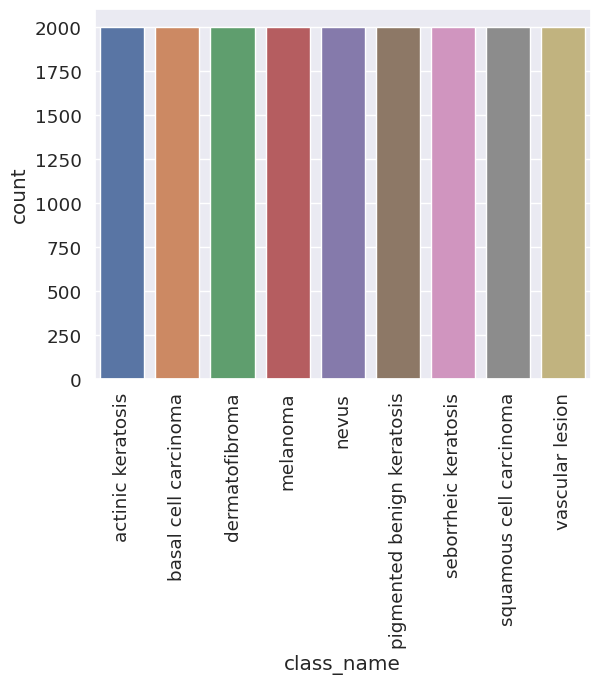

In [ ]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(data_dir_train.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [ ]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [ ]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df=df2
new_df = original_df.append(df2)

In [ ]:
new_df['Label'].value_counts()

dermatofibroma                4000
pigmented benign keratosis    4000
vascular lesion               4000
nevus                         4000
basal cell carcinoma          4000
melanoma                      4000
actinic keratosis             4000
squamous cell carcinoma       4000
seborrheic keratosis          4000
Name: Label, dtype: int64

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

**Training Data**

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="training",
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 20239 files belonging to 9 classes.
Using 16192 files for training.


**Validation Data**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    validation_split=0.2,
    subset="validation",
    labels="inferred",
    label_mode="categorical",
    seed=123,
    image_size=image_size,
    batch_size=batch_size,
)

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


**Create a Model**

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)

    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x

    for size in [128, 256]:  # Experiment with different sizes
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])
        previous_block_activation = x

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    activation = "softmax"
    units = num_classes

    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=num_classes)

In [ ]:
## your code goes here
### Todo, choose an appropirate optimiser and loss function
lr = 0.0001
model.compile(optimizer=keras.optimizers.Adam(lr),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy','Precision','Recall','AUC'])

In [ ]:
# View the summary of all layers
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 180, 180, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 180, 180, 3)          0         ['input_7[0][0]']             
                                                                                                  
 rescaling_6 (Rescaling)     (None, 180, 180, 3)          0         ['sequential[4][0]']          
                                                                                                  
 conv2d_20 (Conv2D)          (None, 90, 90, 32)           896       ['rescaling_6[0][0]']         
                                                                                            

In [ ]:
epochs = 25
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/25
506/506 [==============================] - 123s 227ms/step - loss: 1.6547 - accuracy: 0.3728 - precision: 0.5875 - recall: 0.1543 - auc: 0.8154 - val_loss: 2.2316 - val_accuracy: 0.1376 - val_precision: 1.0000 - val_recall: 0.0151 - val_auc: 0.6201
Epoch 2/25
506/506 [==============================] - 111s 217ms/step - loss: 1.4277 - accuracy: 0.4612 - precision: 0.6501 - recall: 0.2439 - auc: 0.8684 - val_loss: 1.3372 - val_accuracy: 0.4821 - val_precision: 0.6839 - val_recall: 0.2614 - val_auc: 0.8846
Epoch 3/25
506/506 [==============================] - 110s 215ms/step - loss: 1.3336 - accuracy: 0.4897 - precision: 0.6756 - recall: 0.2840 - auc: 0.8864 - val_loss: 1.2007 - val_accuracy: 0.5461 - val_precision: 0.7213 - val_recall: 0.3153 - val_auc: 0.9087
Epoch 4/25
506/506 [==============================] - 112s 219ms/step - loss: 1.2667 - accuracy: 0.5150 - precision: 0.6838 - recall: 0.3151 - auc: 0.8981 - val_loss: 1.1064 - val_accuracy: 0.5836 - val_precision: 0.7619

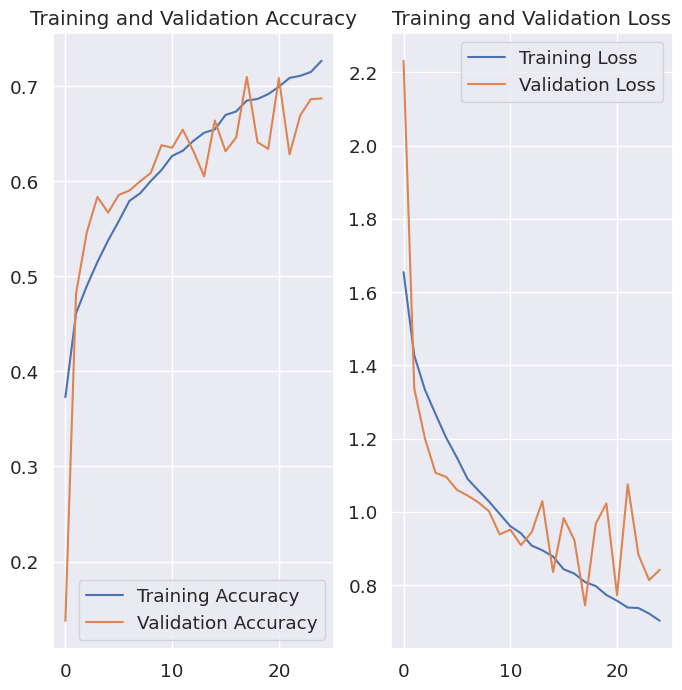

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Conclusion**

*   In this we have two dropout layers (0.3, 0.5) as well as taken differnet sizes (128,256) to overcome overfitting.
*   We have trained 16000 images appox. with lr = 0.0001 and accuracy is coming out to be 72.68%.

